# Data visualisation of Catalonia's demographics in 2018.

Author: Manel López Melià.

Source: All datasets in this work can be downloaded at https://www.idescat.cat/serveis/consultes/.

The aim of this project is to plot data in different ways, so the most necessary package to import is matplotlib. The datasets are loaded in pandas dataframes and numpy is used to create some arrays for the plots, so these two packages have to be imported too.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Say the datasets are stored in a directory called 'data'. Before importing a file, a good practice is to skim over it with a command like:

!head 'data/p2018_municipis_any_any.csv'

Now we know that we can skip the first three rows and that the separations between cells are ';', not the default ','.

In [5]:
filename = 'data/p2018_municipis_any_any.csv'
indices = ['Municipi', 'Edats']
columns = ['Homes', 'Dones', 'Total']
population_1yr = pd.read_csv(filename, skiprows=3, sep=';', thousands='.', encoding='latin1', usecols=indices+columns)

population_1yr = population_1yr.set_index(indices)

population_1yr[['Homes', 'Dones', 'Total']] = population_1yr[['Homes', 'Dones', 'Total']].apply(pd.to_numeric)

To drop rows with missing values, execute:

In [8]:
population_1yr = population_1yr.dropna()

We can check there are no missing values now by executing:

In [9]:
population_1yr.isnull().sum().sum()

0

### Olot's demographics (2018).

A subset of the whole dataset can be taken: the population of the city of Olot. As can be seen in the !head command executed above, there are spaces before the town and ages labels, so the index to use is ' Olot', not 'Olot'.

The last row of each town subset is the total of each column. For this example, this row is omitted.

Also, instead of the indices of ages, a set of numeric indices can be set.

In [11]:
population_1yr_olot = population_1yr.loc[' Olot', :]
population_1yr_olot = population_1yr_olot.loc[' De 0 anys':' De 100 anys i més']

index = pd.Index([i for i in range(101)])
population_1yr_olot = population_1yr_olot.set_index(index)

Let's see how this subset looks:

In [12]:
population_1yr_olot.sample(5)

,Homes,Dones,Total
69,153.0,192.0,345.0
42,298.0,264.0,562.0
73,113.0,150.0,263.0
75,114.0,122.0,236.0
72,134.0,156.0,290.0


A simple plot of this data can be done executing the lines:

In [13]:
men = population_1yr_olot['Homes']
women = population_1yr_olot['Dones']

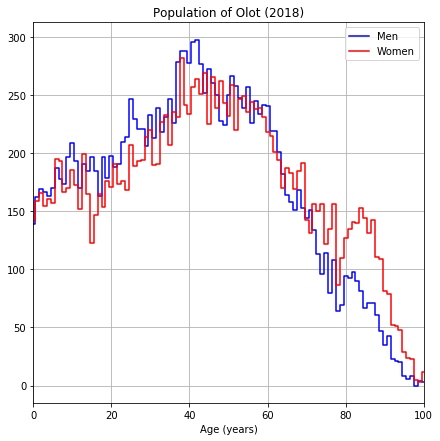

In [14]:
plt.title('Population of Olot (2018)')
plt.xlabel('Age (years)')

men.plot(figsize=(7, 7), color='blue', drawstyle='steps-mid', label='Men')
women.plot(color='red', drawstyle='steps-mid', label='Women')

plt.legend()
plt.grid()
plt.show()

It looks like for ages below 50 years the population of men is greater than women's and viceversa for ages above 60 years. This observation is better seen by plotting the difference between men and women, like this:

In [15]:
difference = men - women

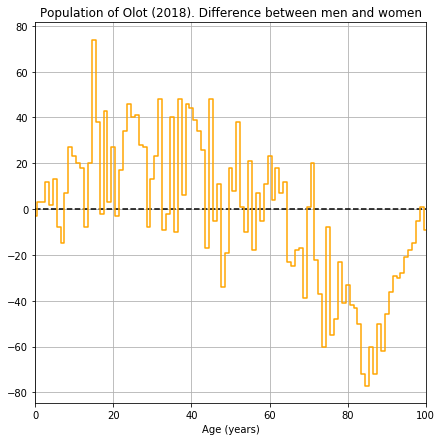

In [16]:
plt.title('Population of Olot (2018). Difference between men and women')
plt.xlabel('Age (years)')

plt.axhline(0, color='black', linestyle='--')
difference.plot(figsize=(7, 7), color='orange', drawstyle='steps-mid')

plt.grid()
plt.show()

If each bin of age is normalized with respect to its total, a stacked bar chart can be plotted so these predominances can be better observed:

In [17]:
total = population_1yr_olot['Total']

men_norm = men / total
women_norm = women / total

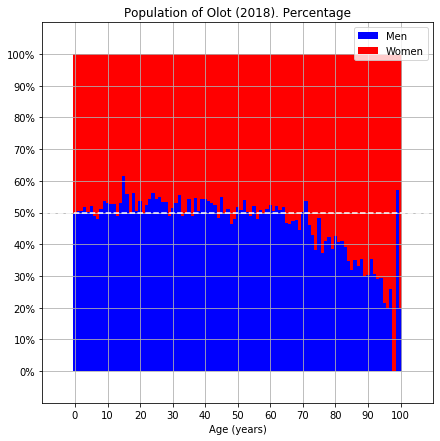

In [18]:
plt.title('Population of Olot (2018). Percentage')
plt.xlabel('Age (years)')

plt.axhline(0.5, color='white', linestyle='--')
men_norm.plot.bar(figsize=(7, 7), color='blue', label='Men', width=1)
women_norm.plot.bar(color='red', label='Women', bottom=men_norm, width=1)

plt.xticks(np.arange(0, 101, 10), np.arange(0, 101, 10), rotation=0)
plt.yticks(np.arange(0, 1.1, 0.1), [str(10*i) + '%' for i in range(11)])
plt.xlim(-10, 110)
plt.ylim(-0.1, 1.1)

plt.legend()
plt.grid()
plt.show()

In the graph above it can be seen how the men population is slightly greater than women's for ages up to 40 years, as commented, although the percentages are practically 50% for men and women. On the other hand, above 60 years the predominance of women is clear, reaching more than 70% for ages above 90 years.

The explanation for this "fall" in the graph could be because of women's higher life expectancy.

This graph can be repeated in binary: a bar is blue if there's more men than women and red else.

In [19]:
men_bin = men_norm

men_bin[men_bin > 0.5] = 1
men_bin[men_bin < 0.5] = 0
women_bin = 1 - men_bin

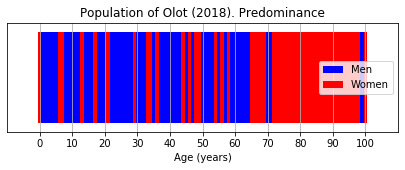

In [20]:
plt.title('Population of Olot (2018). Predominance')
plt.xlabel('Age (years)')

men_bin.plot.bar(figsize=(7, 2), color='blue', label='Men', width=1)
women_bin.plot.bar(color='red', label='Women', bottom=men_bin, width=1)

plt.xticks(np.arange(0, 101, 10), np.arange(0, 101, 10), rotation=0)
plt.xlim(-10, 110)
plt.ylim(-0.1, 1.1)

plt.tick_params(axis='y', left=False, labelleft=False)

plt.legend()
plt.grid(axis='x')
plt.show()

Again, in this graph the predominance of women in ages above 60 years can be observed.

A population pyramid can be also plotted executing:

In [21]:
men = men.apply(lambda x: -x)

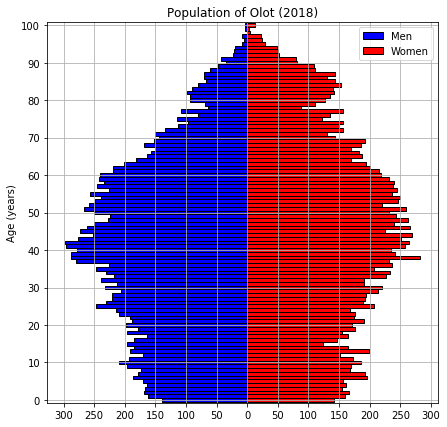

In [22]:
plt.title('Population of Olot (2018)')
plt.ylabel('Age (years)')

men.plot.barh(figsize=(7, 7), color='blue', edgecolor='black', label='Men', width=1)
women.plot.barh(color='red', edgecolor='black', label='Women', width=1)

plt.xticks(np.arange(-300, 301, 50), np.abs(np.arange(-300, 301, 50)))
plt.yticks(np.arange(0, 101, 10), np.arange(0, 101, 10))

plt.legend()
plt.grid()
plt.show()

Like in previous graphs, it can be seen how the population pyramid is practically symmetric for ages below 40 years, meaning that there are as much men than women in each bin, and for ages greater than 60 years the population of men decreases more than women's, especially in the interval of 80 to 90 years.

Concerning the shape of this population pyramid, and that of some of the previous graphs, the explanation for its large width in the interval of ages from 40 to 60 years corresponds to the so-called baby-boom generation. Indeed, the increase of birth rate in Spain was approximately from the 60s to the 80s.

In all these graphs the difference between bins is sometimes great, making them look irregular in some occasions. This is, of course, due to the fact that the data is in bins of 1 year only. By changing to bins of 5 years, these irregularities will be smoothed and there will be less noise.

Like before, let's first print the first lines of the file:

In [23]:
!head 'p2018_municipis_quinquenal.csv'

The next step is reading the file. Like in the previous case, some columns are not considered and some are set as indices:

In [24]:
filename = 'p2018_municipis_quinquenal.csv'
indices = ['Municipi', 'Edat']
columns = ['Homes', 'Dones', 'Total']
population_5yr = pd.read_csv(filename, skiprows=3, sep=';', thousands='.', encoding='latin1', usecols=indices+columns)

population_5yr = population_5yr.set_index(indices)

population_5yr[['Homes', 'Dones', 'Total']] = population_5yr[['Homes', 'Dones', 'Total']].apply(pd.to_numeric)

The rows with missing values (the last row) are dropped:

In [25]:
population_5yr.tail()

Homes  Dones   Total
Municipi Edat                                    
 Xerta    De 90 a 94 anys      4.0   12.0    16.0
          De 95 a 99 anys      1.0    3.0     4.0
          De 100 anys i més    0.0    1.0     1.0
          Total              570.0  600.0  1170.0
NaN      NaN                   NaN    NaN     NaN

In [26]:
population_5yr.isnull().sum().sum()

3

In [27]:
population_5yr = population_5yr.dropna()

In [28]:
population_5yr.tail()

Homes  Dones   Total
Municipi Edat                                    
 Xerta    De 85 a 89 anys     14.0   38.0    52.0
          De 90 a 94 anys      4.0   12.0    16.0
          De 95 a 99 anys      1.0    3.0     4.0
          De 100 anys i més    0.0    1.0     1.0
          Total              570.0  600.0  1170.0

In [29]:
population_5yr.isnull().sum().sum()

0

The subset of population of Olot is taken:

In [30]:
population_5yr_olot = population_5yr.loc[' Olot', :]
population_5yr_olot = population_5yr_olot.loc[' De 0 a 4 anys':' De 100 anys i més']

array = [str(5*i) + ' to ' + str(5*i + 4) for i in range(20)] + ['100 or more']
index = pd.Index(array)
population_5yr_olot = population_5yr_olot.set_index(index)

And it is plotted:

In [31]:
men = population_5yr_olot['Homes']
women = population_5yr_olot['Dones']

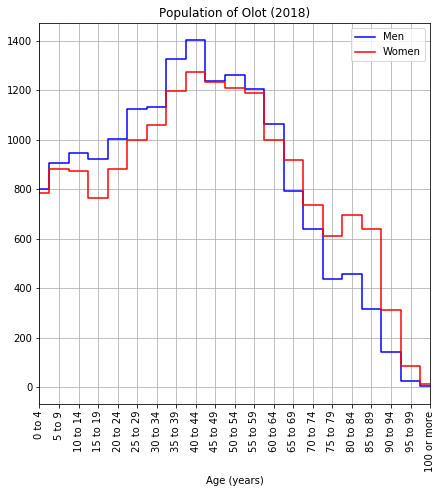

In [32]:
plt.title('Population of Olot (2018)')
plt.xlabel('Age (years)')

men.plot(figsize=(7, 7), color='blue', drawstyle='steps-mid', label='Men')
women.plot(color='red', drawstyle='steps-mid', label='Women')

plt.xticks(range(len(array)), array, rotation=90)

plt.legend()
plt.grid()
plt.show()

As expected, now there are less irregularities: the predominance of men is uninterrupted for ages up to 44 years and the same can be said of women for ages from 65 years to 100 or more.

Let's repeat the rest of the plots again. First, the differences between men and women:

In [33]:
difference = men - women

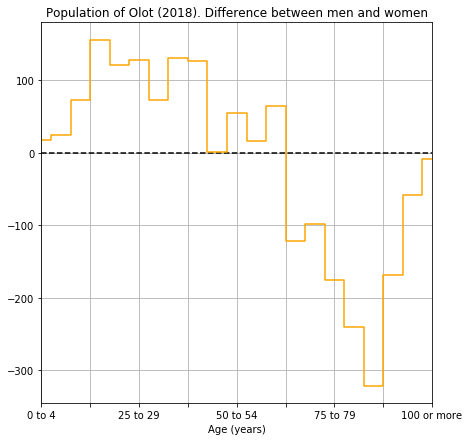

In [34]:
plt.title('Population of Olot (2018). Difference between men and women')
plt.xlabel('Age (years)')

plt.axhline(0, color='black', linestyle='--')
difference.plot(figsize=(7, 7), color='orange', drawstyle='steps-mid')

plt.grid()
plt.show()

Next, the percentages:

In [35]:
total = population_5yr_olot['Total']

men_norm = men / total
women_norm = women / total

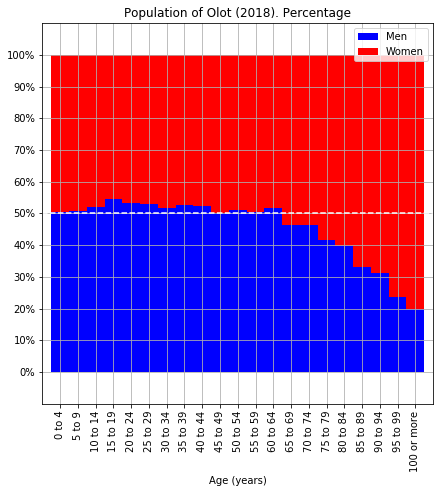

In [36]:
plt.title('Population of Olot (2018). Percentage')
plt.xlabel('Age (years)')

plt.axhline(0.5, color='white', linestyle='--')
men_norm.plot.bar(figsize=(7, 7), color='blue', label='Men', width=1)
women_norm.plot.bar(color='red', label='Women', bottom=men_norm, width=1)

plt.yticks(np.arange(0, 1.1, 0.1), [str(10*i) + '%' for i in range(11)])
plt.xlim(-1, 21)
plt.ylim(-0.1, 1.1)

plt.legend()
plt.grid()
plt.show()

Finally, the predominance:

In [37]:
men_bin = men_norm

men_bin[men_bin > 0.5] = 1
men_bin[men_bin < 0.5] = 0
women_bin = 1 - men_bin

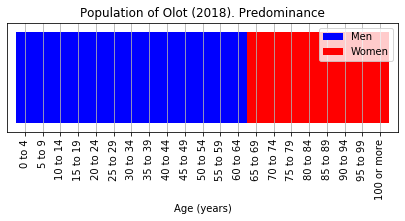

In [38]:
plt.title('Population of Olot (2018). Predominance')
plt.xlabel('Age (years)')

men_bin.plot.bar(figsize=(7, 2), color='blue', label='Men', width=1)
women_bin.plot.bar(color='red', label='Women', bottom=men_bin, width=1)

plt.xlim(-1, 21)
plt.ylim(-0.1, 1.1)

plt.tick_params(axis='y', left=False, labelleft=False)

plt.legend()
plt.grid(axis='x')
plt.show()

This last graph is the most clear example of how smooth the data is now in comparison with the previous dataset. There are no irregularities at all: the predominances are uninterrupted, with no peaks, with no exceptions.

The population pyramid of this dataset is also obtained:

In [39]:
men = men.apply(lambda x: -x)

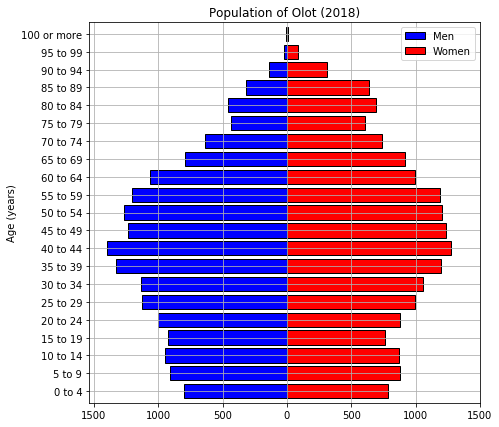

In [40]:
plt.title('Population of Olot (2018)')
plt.ylabel('Age (years)')

men.plot.barh(figsize=(7, 7), color='blue', edgecolor='black', label='Men', width=0.8)
women.plot.barh(color='red', edgecolor='black', label='Women', width=0.8)

plt.xticks((-1500, -1000, -500, 0, 500, 1000, 1500), (1500, 1000, 500, 0, 500, 1000, 1500))

plt.legend()
plt.grid()
plt.show()

As before the baby-boom generation can be observed in the bins of ages from 35 to 60 years.

What about immigration? How much of Olot's population in 2018 is not Catalan? Or not even Spanish? There's another file to analise this factor. Let's read the first lines:

In [41]:
!head 'p2018_municipis_llnaix.csv'

There are many interesting columns, in this dataset: for each town, there's the number of men, women and total that were born in Catalonia, in Spain or abroad. Also, within those born in Catalonia, there's the distinction of the four provincies: Barcelona, Girona, Lleida and Tarragona; within those born in Spain, there are the sixteen other autonomous communities (excepting Catalonia) and the two autonomous cities together: Ceuta and Melilla.

In [42]:
filename = 'p2018_municipis_llnaix.csv'
indices = ['Municipi', 'Sexe']
columns = ['Catalunya', "Resta d'Espanya", 'Estranger',
           'Barcelona', 'Girona', 'Lleida', 'Tarragona',
           'Andalusia', 'Aragó', "Principat d'Astúries", 'Illes Balears', 'Canàries', 'Cantàbria',
           'Castella - la Manxa', 'Castella i Lleó', 'Comunitat Valenciana', 'Extremadura', 'Galícia',
           'Comunitat de Madrid', 'Regió de Múrcia', 'Comunitat Foral de Navarra', 'País Basc', 'Rioja, La',
           'Ceuta i Melilla']
population_pob = pd.read_csv(filename, skiprows=5, sep=';', thousands='.', encoding='latin1', usecols=indices+columns)

population_pob = population_pob.set_index(indices)

population_pob[columns] = population_pob[columns].apply(pd.to_numeric)

Again, there are missing values in the last row:

In [43]:
population_pob.tail()

Catalunya  Barcelona  Girona  Lleida  Tarragona  \
Municipi           Sexe                                                      
 Viver i Serrateix  Total      158.0      148.0     3.0     6.0        1.0   
 Xerta              Homes      484.0       53.0     3.0     3.0      425.0   
                    Dones      510.0       62.0     4.0     2.0      442.0   
                    Total      994.0      115.0     7.0     5.0      867.0   
NaN                NaN           NaN        NaN     NaN     NaN        NaN   

                           Resta d'Espanya  Andalusia  Aragó  \
Municipi           Sexe                                        
 Viver i Serrateix  Total              4.0        2.0    0.0   
 Xerta              Homes             42.0       12.0    7.0   
                    Dones             41.0        9.0    6.0   
                    Total             83.0       21.0   13.0   
NaN                NaN                 NaN        NaN    NaN   

                           Principat d'Astúries  Illes Balears  ...  \
Municipi           Sexe                                         ...   
 Viver i Serrateix  Total                   0.0            0.0  ...   
 Xerta              Homes                   0.0            0.0  ...   
                    Dones                   0.0            0.0  ...   
                    Total                   0.0            0.0  ...   
NaN                NaN                      NaN            NaN  ...   

                           Comunitat Valenciana  Extremadura  Galícia  \
Municipi           Sexe                                                 
 Viver i Serrateix  Total                   0.0          1.0      0.0   
 Xerta              Homes                  10.0          3.0      4.0   
                    Dones                  11.0          0.0      7.0   
                    Total                  21.0          3.0     11.0   
NaN                NaN                      NaN          NaN      NaN   

                           Comunitat de Madrid  Regió de Múrcia  \
Municipi           Sexe                                           
 Viver i Serrateix  Total                  1.0              0.0   
 Xerta              Homes                  0.0              1.0   
                    Dones                  3.0              0.0   
                    Total                  3.0              1.0   
NaN                NaN                     NaN              NaN   

                           Comunitat Foral de Navarra  País Basc  Rioja, La  \
Municipi           Sexe                                                       
 Viver i Serrateix  Total                         0.0        0.0        0.0   
 Xerta              Homes                         0.0        0.0        1.0   
                    Dones                         0.0        1.0        0.0   
                    Total                         0.0        1.0        1.0   
NaN                NaN                            NaN        NaN        NaN   

                           Ceuta i Melilla  Estranger  
Municipi           Sexe                                
 Viver i Serrateix  Total              0.0        2.0  
 Xerta              Homes              0.0       44.0  
                    Dones              0.0       49.0  
                    Total              0.0       93.0  
NaN                NaN                 NaN        NaN  

[5 rows x 24 columns]

In [44]:
population_pob.isnull().sum().sum()

24

They can be dropped like this:

In [45]:
population_pob = population_pob.dropna()

In [46]:
population_pob.isnull().sum().sum()

0

Now the subset of Olot's population is taken:

In [47]:
population_pob_olot = population_pob.loc[' Olot', :]

index = pd.Index(['Men', 'Women', 'Total'])
population_pob_olot = population_pob_olot.set_index(index)

For technical reasons (to obtain a plot with men, women and total bars together), the dataset has to be transposed:

In [48]:
population_pob_olot = population_pob_olot.T

Now only the three most generic columns (that are now rows) are taken, those corresponding to people born in Catalonia, somewhere else in Spain or somewhere else abroad:

In [49]:
general = population_pob_olot.loc[['Catalunya', "Resta d'Espanya", 'Estranger']]

In [50]:
general

,Men,Women,Total
Catalunya,11303.0,12020.0,23323.0
Resta d'Espanya,1614.0,1806.0,3420.0
Estranger,4222.0,3521.0,7743.0


These subset is plotted:

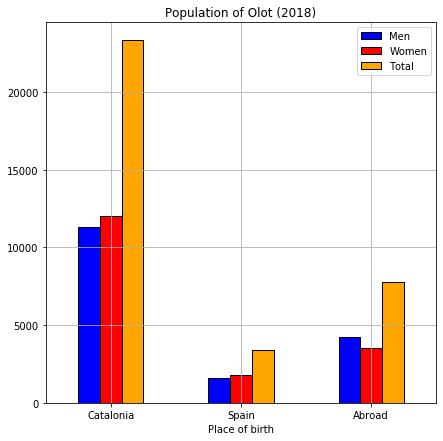

In [51]:
general.plot.bar(figsize=(7, 7), color=('blue', 'red', 'orange'), edgecolor='black')

plt.title('Population of Olot (2018)')
plt.xlabel('Place of birth')

plt.xticks(range(3), ['Catalonia', 'Spain', 'Abroad'], rotation=0)

plt.grid()
plt.show()

The plot above can be improved if scaled to the total population of Olot: with percentages, the bins will be better understood.

A dataset of the total men, women and unisex population of each town is taken:

In [52]:
population_total = population_5yr.loc[(slice(None), ' Total'),:]

# the index 'Edat' is now useless, so it can be dropped:
population_total = population_total.reset_index().drop('Edat', axis=1).set_index('Municipi')
population_total.columns = ['Men', 'Women', 'Total']

This way, to obtain the total men and women living in Olot, the line below has to be executed:

In [53]:
total = population_total.loc[' Olot', 'Total']
total

34486.0

The previous dataset is easily scaled:

In [54]:
general_scaled = 100 * general / total

And plotted:

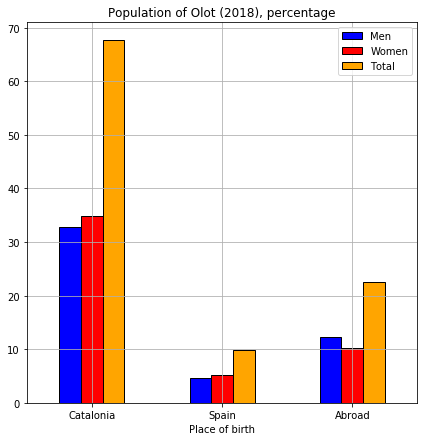

In [55]:
general_scaled.plot.bar(figsize=(7, 7), color=('blue', 'red', 'orange'), edgecolor='black')

plt.title('Population of Olot (2018), percentage')
plt.xlabel('Place of birth')

plt.xticks(range(3), ['Catalonia', 'Spain', 'Abroad'], rotation=0)

plt.grid()
plt.show()

Now it's much easier to see that around 68% of Olot people has been born in Catalonia, 10% are Spanish but not Catalan and around 22% have been born abroad. Numerically:

In [56]:
print(
    "Catalonia: {:.2f}%\nSpain: {:.2f}%\nAbroad: {:.2f}%".format(
                general_scaled.loc['Catalunya', 'Total'],
                general_scaled.loc["Resta d'Espanya", 'Total'],
                general_scaled.loc['Estranger', 'Total']))

Catalonia: 67.63%
Spain: 9.92%
Abroad: 22.45%
